## Flattening the curve
The oft mentioned curve is the "infected" curve from the family of SIR models (Susceptible, Infected, Removed). In the simulation below, the I curve is in red. In this case it shows the fraction of the population infected at any given time. The objective is to keep that peak below hospital capacity to prevent the health care system from being overwhelmed. There are many strategies available for doing that, but they depend on the disease. With COVID-19, we lack a vaccine, there are no cures, and the duration of the disease can be quite long. If we assume that recovery confers immunity, then the options available come down to managing the rates of infection, and treatments that shorten hospitalization time. 

Here will be using the most basic SIR model. I will not go into the equations and so on, but I encourage you to look it up. Here's a link to a very fun Numberphile video.
https://youtu.be/k6nLfCbAzgo

In the simulation below, population is normalized to a maximum of 1.0, the overall infection rate is b ($\beta$), and the rate at which infected persons are removed from the population ($\gamma$) rate is g. $\beta$ is a combination of several factors: the average number of contacts per person per time, multiplied by the probability of disease transmission in a contact between a susceptible and an infectious subject. SIP orders focus on reducing the average number of contacts, while hygiene mechanisms (masks, washing hands, etc.) focus on the probability of transmission. The following estimates or values are used:
1. $N$ is the total population of Los Angeles County - 10,098,052.
2. The number of hospital beds, $H(0)\approx 23,579$.
3. The fraction of the susceptible population on March 2nd, $S(0)= 0.999998$.
3. Fraction of population infected, $I$, $\therefore = 0.000002$.
4. The duration of the disease is taken to be 14 days, $\therefore \gamma=1/14=0.07$.
5. $R_0$: The basic reproduction number is defined as the number of cases that are expected to occur on average in a homogeneous population as a result of infection by a single individual, when the population is susceptible at the start of an epidemic, before widespread immunity starts to develop and before any attempt has been made at immunization. The value used here is at the high end of early estimates made in east Asia, namely from Wuhan and South Korea. Those are the rates that we are very afraid of. Here I use 4.5.
6. $\beta$ can be estimated as $R_0 = \beta/\gamma$, and $\therefore \beta\approx 0.3$.

Let's run the model for 200 days.

In [13]:
fred = Array{Float64,2}
fred[1,1] = 6

MethodError: MethodError: no method matching setindex!(::Type{Array{Float64,2}}, ::Int64, ::Int64, ::Int64)

In [18]:
joe = Array{Float64}(undef,2,4)
joe[1,1] = 6
joe[2,2] = 7
joe
rows=511
io1a = Array{Float64}(undef,rows,81)
io1a[2,1]=6


MethodError: MethodError: no method matching setindex!(::Float64, ::Int64, ::Int64)

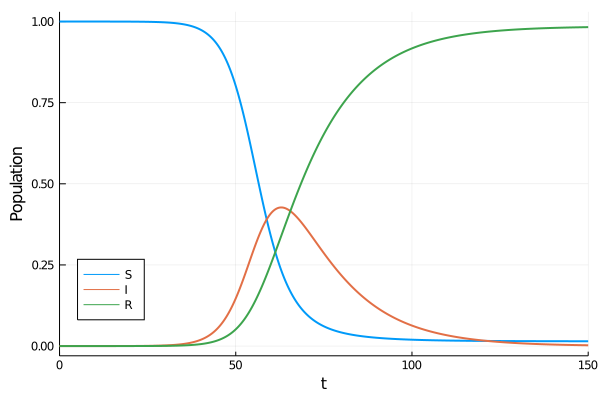

In [13]:
using DifferentialEquations

function sir_ode1(du,u,p,t)
    S,I,R = u
    b,g = p
    du[1] = -b*S*I
    du[2] = b*S*I-g*I
    du[3] = g*I
end
parms = [.3,0.07]
init = [0.999998,0.000002,0.0]
tspan = (0.0,150.0)
sir_prob1 = ODEProblem(sir_ode1,init,tspan,parms)
sir_sol1 = solve(sir_prob1,saveat = 0.1)
plot(sir_sol1,lw=2,ylabel="Population",label=["S" "I" "R"],leg=:bottomleft)

The disease is a slow burn, primarily because of the low estimate for $R_0$. Other diseases, such as measels, will have an $R_0=15$! But within 2 months the number of infected persons begins to grow exponentially. Given a hospital bed capacity of 0.002, the system would be overwhelmed within two months! One way to manage this is to reduce $\beta$ dramatically, most practically by reducing $R$. That is the logic behind "flattening the curve". Let's say that we were able to cut $R_0$ in half with the immediate implementation of a shutdown, then $\beta\approx 0.1575$. What is the result?

In [2]:
parms = [.1575,0.07]
init = [0.999998,0.000002,0.0]
tspan = (0.0,250.0)
sir_prob2 = ODEProblem(sir_ode1,init,tspan,parms)
sir_sol2 = solve(sir_prob2,saveat = 0.1)
plot(sir_sol2,lw=2,ylabel="Population",label=["S" "I" "R"],leg=:bottomleft)

UndefVarError: UndefVarError: plot not defined

The peak still exceeds hospital capacity. But notice that the time to the peak, in fact the time to have the outbreak sweep through the population, is now greatly increased. Many things can change during the time, and our parameters here are static. The assumptions are that the amount of time gained will be used to develop effective treatments, develop a vaccine, and increase coping measures such as ventilators.

An effective way to both compare the two simulations, as well as the impact of changing $R_0$, is to re-scale the equations to the duration time ($\gamma$). If we let $\tau=\gamma t$, then the equations become
$$
\begin{align}
& \frac{ds}{d\tau} = R_0is \\
& \frac{di}{d\tau} = R_0is-i \\
& \frac{dr}{d\tau} = i
\end{align}
$$

In [3]:
function sir_ode2(du,u,p,t)
    s,i,r = u
    R = p
    du[1] = -R*s*i
    du[2] = R*s*i-i
    du[3] = i
end
parms = 4.5
init = [0.999998,0.000002,0.0]
tspan = (0.0,30.0)
sir_prob2 = ODEProblem(sir_ode2,init,tspan,parms)
sir_sol2 = solve(sir_prob2,saveat = 0.1)

parms = 2.25
init = [0.999998,0.000002,0.0]
tspan = (0.0,20.0)
sir_prob3 = ODEProblem(sir_ode2,init,tspan,parms)
sir_sol3 = solve(sir_prob3,saveat = 0.1)

plot(sir_sol2,lw=2,ylabel="Population",label=["S" "I" "R"],leg=:bottomleft)
plot!(sir_sol3,lw=2,leg=false)

UndefVarError: UndefVarError: plot not defined

A bit of a confusing plot with two simulations, but the shift of the infected curves is obvious. A nicer way to visualize the comparison is with a phase plot. You lose the timescale, but curve flattening is now very obvious.

In [4]:
U2 = Array(sir_sol2)
U3 = Array(sir_sol3)
plot(U2[1,:],U2[2,:],lw=2,xlims=(0.0,1.0),ylims=(0.0,0.5),xlabel="Susceptible",ylabel="Infected",label="R0=4.5")
plot!(U3[1,:],U3[2,:],lw=2,label="R0=2.25")

UndefVarError: UndefVarError: plot not defined

Let's extend this now to examine a full range of values of $R_0$ and curve flattenings.

In [5]:
sols = Array{Float64}(undef,22,201)
tally = [1]
for i = 1:11
    parms = 0.65 + (i*0.35)
    init = [0.999998,0.000002,0.0]
    tspan = (0.0,20.0)
    sir_prob4 = ODEProblem(sir_ode2,init,tspan,parms)
    sir_sol4 = solve(sir_prob4,saveat = 0.1)
    sol = Array(sir_sol4)
    for j = 1:201
        sols[tally[1],j] = sol[1,j]
        sols[tally[1]+1,j] = sol[2,j]
    end
    tally[1] = tally[1] + 2
end

plot(sols[1,:],sols[2,:],xlims=(0.0,1.0),ylims=(0.0,0.5),lw=2,xlabel="Susceptible",ylabel="Infected",leg=false)
plot!(sols[3,:],sols[4,:],lw=2)
plot!(sols[5,:],sols[6,:],lw=2)
plot!(sols[7,:],sols[8,:],lw=2)
plot!(sols[9,:],sols[10,:],lw=2)
plot!(sols[11,:],sols[12,:],lw=2)
plot!(sols[13,:],sols[14,:],lw=2)
plot!(sols[15,:],sols[16,:],lw=2)
plot!(sols[17,:],sols[18,:],lw=2)
plot!(sols[19,:],sols[20,:],lw=2,label="R0=4.5")

UndefVarError: UndefVarError: plot not defined

Overall, the lower the value of $R_0$, the lower peak infection.

## Business as usual
The first question that we'll address is, what would be the consequences to the economy if no measures were taken to disrupt the outbreak? We will simply take the infection curves above, and determine from the fraction of the population infected each day, how many of those persons would be in the workforce, and how many of them have been removed from the population because of death or hospitalization.

In [6]:
using StatsPlots, DelimitedFiles, CSV, Plots, DataFrames
# reading a delimited file
I = readdlm("US_exchanges_2018c.csv")

15×15 Array{Float64,2}:
 1.28153    0.0135159  0.00773    …  0.0156276  0.0094602  0.0146184
 0.0372335  1.11834    0.093211      0.0151296  0.0138087  0.0268551
 0.0184729  0.0166119  1.04222       0.021795   0.008112   0.0099787
 0.0120597  0.012506   0.0193105     0.0076677  0.0087455  0.0287984
 0.387082   0.236255   0.134891      0.1598     0.159384   0.223719
 0.150443   0.0526213  0.03145    …  0.0374893  0.0335185  0.0431247
 0.0083378  0.0036551  0.0075759     0.0077494  0.012921   0.0033437
 0.0681456  0.0521195  0.0750681     0.0267532  0.0229341  0.0362094
 0.0195425  0.0257214  0.0222736     0.0384731  0.0409086  0.0452146
 0.186783   0.136408   0.0748774     0.165861   0.157982   0.0864993
 0.0992767  0.169228   0.114341   …  0.194094   0.129072   0.126296
 0.0005429  0.0003333  0.0007803     0.0017449  0.0048802  0.0079003
 0.0088715  0.0086924  0.0105185     1.03519    0.0162784  0.0114603
 0.0092786  0.0070565  0.0051895     0.0163076  1.01573    0.0135882
 0.0222345  

In [7]:
employed = CSV.read("LA_employment_by_sector_2020.csv")

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /Users/joe/.julia/packages/CSV/hZ1pV/src/CSV.jl:40


,Sector,Jan,Feb,Mar,Apr,May,Jan_Feb
,String,Int64,Int64,Int64,Int64,Int64,Float64
1,Total farm,4300,4400,4200,3800,3700,-0.000232558
2,Mining and logging,1900,1900,1900,1900,2000,0.0
3,Utilities,12200,12200,12200,12300,12300,0.0
4,Construction,151400,152600,148900,130900,143100,-7.92602e-5
5,Manufacturing,335800,336600,328900,291400,306700,-2.38237e-5
6,Wholesale trade,218200,218700,217000,196200,204200,-2.29148e-5
7,Retail trade,420900,415800,413800,339600,341700,0.000121169
8,Transportation and warehousing,207500,205800,203700,185500,183700,8.19277e-5
9,Information,227500,241000,234300,183400,174400,-0.000593407


In [8]:
no_sectors = size(I,1)

# beta and gamma matrices
A = Array{Float64}(undef,no_sectors,no_sectors)
B = Array{Float64}(undef,no_sectors,no_sectors)
C = Array{Float64}(undef,no_sectors,no_sectors)
abc = Float64[]
for i = 1:no_sectors
    row_sum = 0.0
    for j = 1:no_sectors
        row_sum = row_sum +I[i,j] + I[j,i]
    end
    row_sum = row_sum - I[i,i]
    push!(abc,row_sum)
end
#print(abc)

        
for i = 1:no_sectors
    #abc = sum(I[:,1])+sum(I[1,:])-(I[1,1])
    for j = 1:no_sectors
        A[i,j] = 0.0
        B[i,j] = I[j,i]/abc[i]
        C[i,j] = I[i,j]/abc[i]
    end
    A[i,i] = I[i,i]/abc[i]
    B[i,i] = 0.0
    C[i,i] = 0.0
end
#print(B)

As of July 26, total deaths in the US is around 146,934. Of those, approximately 26,000 were of working age. The mortality rate for working aged individuals than is around 0.18. That's quite high. The hospitalization rate for the same group is around 0.02, also high. But let's focus on mortality alone for now. The expected daily death rate in the employment force can be calculated from the "removed" compartment in the above model from the overall lethality rate of the disease. Given that to date 4,233,764 persons in the US have been confirmed as infected, the lethality rate is around 0.03. The number of workers in that fraction, given that approximately 45.3% of the LA population is employed, is then the lethality rate times the number of removed, times the fraction of those who are expected to be of working age (0.453),
$$
\delta(t) = 0.03\times0.453\times[R(t+1)-R(t)]
$$
where $R(t)$ is the number of persons infected on any given day. Thus, if $R_0$ is 4.5, the expected number of deaths per day in the LA SES is as follows.

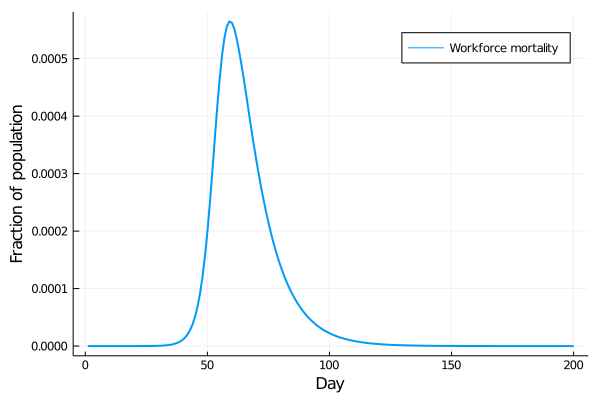

In [9]:
sols = Array{Float64}(undef,22,201)
tally = [1]
for i = 1:11
    parms = 0.65 + (i*0.35)
    init = [0.999998,0.000002,0.0]
    tspan = (0.0,20.0)
    sir_prob4 = ODEProblem(sir_ode2,init,tspan,parms)
    sir_sol4 = solve(sir_prob4,saveat = 0.1)
    sol = Array(sir_sol4)
    for j = 1:201
        sols[tally[1],j] = sol[1,j]
        sols[tally[1]+1,j] = sol[3,j]
    end
    tally[1] = tally[1] + 2
end

R_45 = sols[20,:]
d = Float64[]
for i = 2:size(R_45,1)
    if i>14
        push!(d,0.03*0.453*(R_45[i-13]-R_45[i-14]))
    else
        push!(d,0.0)
    end
end
#print(d)
plot(d,label="Workforce mortality",xlabel="Day",ylabel="Fraction of population",lw=2)

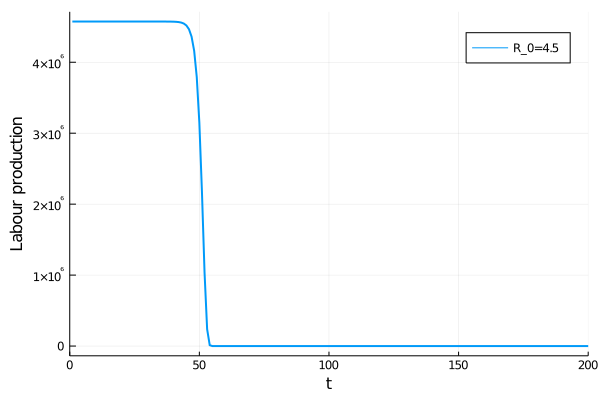

In [10]:
# time
T = 200

# parameter array
# add column vector for time
p = Array{Float64}(undef,T,no_sectors,3)
for i = 1:T
    #p[i,no_sectors+1] = i
    for j = 1:no_sectors
        p[i,j,1] = 0.0
        if i==1
        p[i,j,2] = 0.0
        elseif i>1
            p[i,j,2] = -1.0*d[i]
        end
        p[i,j,3] = 0.0
    end
end
#print(p)

# perturbation
D = Array{Float64}(undef,T,no_sectors)
for i = 1:T
    for j = 1:no_sectors
        D[i,j] = p[i,j,1]+p[i,j,2]+p[i,j,3]
    end
end
#print(D)

# employment
Ep = Array{Float64}(undef,T,no_sectors+1)
Up = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:T
    Ep[i,1] = convert(Float64,i)
    Up[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        Ep[i,j+1] = 0.0
        Up[i,j+1] = 0.0
    end
end
for i = 1:no_sectors
    Ep[1,1] = 1.0
    Ep[1,i+1] = employed[i,:Mar]
    Up[1,1] = 1.0
    Up[1,i+1] = 0.0
end

# simulate
for i = 2:T
    Ep[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+D[i,j])*Ep[i-1,j+1]/Ep[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+D[i,k])*(B[j,k]+C[j,k])*(Ep[i-1,k+1]/Ep[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0.0 # positive growth
            del_E = round(a*(Ep[i-1,j+1]) - Ep[i-1,j+1])
            #println(i," ",del_E)
            if del_E <= Up[i-1,j+1] # if re-hiring possible
                Ep[i,j+1] = round(a*Ep[i-1,j+1]) #+ del_E
                Up[i,j+1] = round((Up[i-1,j+1]*(1-p[2])) + ((Ep[i-1,j+1]-Ep[i,j+1])))*(1-p[2])
            elseif del_E > Up[i-1,j+1]
                Ep[i,j+1] = Ep[i-1,j+1] + Up[i-1,j+1]
                Up[i,j+1] = 0.0
            end
        elseif a-1.0 < 0.0 # negative growth
            del_E = Ep[i-1,j+1] - round(a*(Ep[i-1,j+1]))
            #println(i," ",del_E)
            Ep[i,j+1] = round(a*(Ep[i-1,j+1]))
            Up[i,j+1] = round(Up[i-1,j+1]*(1-p[2]) + (Ep[i-1,j+1]-Ep[i,j+1]))
        end
        # no negative unemployment
        if Up[i,j+1] < 0.0
            Up[i,j+1] = 0.0
        end
        if Up[i,j+1] >= Ep[1,j+1]
            Up[i,j+1] = Ep[1,j+1]
        end
    end
end
#print(E)

# plot
ep = Float64[]
up = Float64[]
for i = 1:T
    push!(ep,sum(Ep[i,:])-Ep[i,1])
    push!(up,sum(Up[i,:])-Up[i,1])
end
plot(ep,xlabel="t",ylabel="Labour production",label="R_0=4.5",lw=2,xlims=(0.0,200.0))
#plot!(up,label="basic press model",lw=2)
#plot(p[:,:,2])

## Cost to flatten the curve
Our next question is, what would the "cost" be to the economy in order to buy this time? Continuing our crude estimates, we wish to reduce the number of daily intimate contacts per person by half. Now, we simply cannot remove 50% of the workforce, because reducing $R$ means isolating or quarantining households. Statista estimated a total of 1,382,293 households in LA in 2018. The average household size is therefore 7.3 persons (yikes). Thus if we isolated or quarantined even half of the households, that represents 691,647 workers.

If we distributed that labour reduction uniformly among the industrial sectors, what would the impact be? The total labour force for LA in February was 4,573,600. The reduction is therefore 15%.

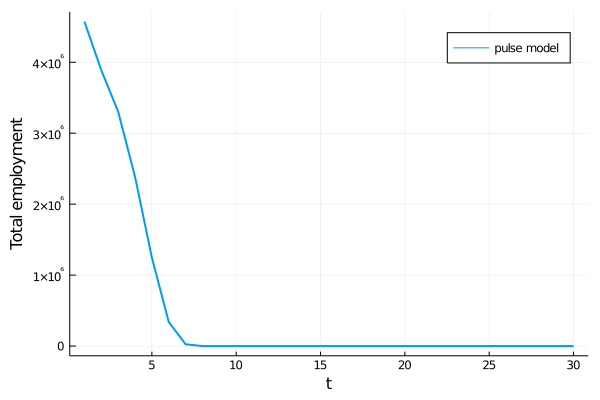

In [12]:
# time
T = 30

# parameter array
# add column vector for time
p = Array{Float64}(undef,T,no_sectors,3)
for i = 1:T
    #p[i,no_sectors+1] = i
    for j = 1:no_sectors
        p[i,j,1] = 0.0
        # no perturbation except when t=2
        if i == 2
            p[i,j,1] = -0.15
        end
        p[i,j,2] = 0.0
        p[i,j,3] = 0.0
    end
end

# perturbation
D = Array{Float64}(undef,T,no_sectors)
for i = 1:T
    for j = 1:no_sectors
        D[i,j] = p[i,j,1]+p[i,j,2]+p[i,j,3]
    end
end
#print(D)

# employment
Ep = Array{Float64}(undef,T,no_sectors+1)
Up = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    Ep[1,1] = 1.0
    Ep[1,i+1] = employed[i,:Mar]
    Up[1,1] = 1.0
    Up[1,i+1] = 0.0
end

# simulate
for i = 2:T
    Ep[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+D[i,j])*Ep[i-1,j+1]/Ep[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+D[i,k])*(B[j,k]+C[j,k])*(Ep[i-1,k+1]/Ep[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(Ep[i-1,j+1]) - Ep[i-1,j+1])
            #println(del_E)
            if del_E <= Up[i-1,j+1] # if re-hiring possible
                Ep[i,j+1] = round(a*Ep[i-1,j+1]) #+ del_E
                Up[i,j+1] = round((Up[i-1,j+1]*(1-p[2])) + ((Ep[i-1,j+1]-Ep[i,j+1])))*(1-p[2])
            elseif del_E > Up[i-1,j+1]
                Ep[i,j+1] = Ep[i-1,j+1] + Up[i-1,j+1]
                Up[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = Ep[i-1,j+1] - round(a*(Ep[i-1,j+1]))
            Ep[i,j+1] = round(a*(Ep[i-1,j+1]))
            Up[i,j+1] = Up[i-1,j+1]*(1-p[2]) + (Ep[i-1,j+1]-Ep[i,j+1])
        end
        # no negative unemployment
        if Up[i,j+1] < 0.0
            Up[i,j+1] = 0.0
        end
        if Up[i,j+1] >= Ep[1,j+1]
            Up[i,j+1] = Ep[1,j+1]
        end
    end
end
#print(E)

# plot
ep = Float64[]
up = Float64[]
for i = 1:T
    push!(ep,sum(Ep[i,:])-Ep[i,1])
    push!(up,sum(Up[i,:])-Up[i,1])
end
plot(ep,xlabel="t",ylabel="Total employment",label="pulse model",lw=2)
#plot!(e,label="basic press model",lw=2)